# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [70]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [71]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [72]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [73]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    x = self.layer1(x)  
    x = self.layer2(x)  
    x = self.output_layer(x, activation=1)  
    return x

In [74]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    pred_labels = tf.argmax(y_pred, axis=1)

    correct_predictions = tf.equal(pred_labels, y_true)
    
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [75]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
  trainable_variables = [neural_net.layer1.w, neural_net.layer1.b, 
                           neural_net.layer2.w, neural_net.layer2.b, 
                           neural_net.output_layer.w, neural_net.output_layer.b]
    # Обчислимо за ними значення градієнта
  gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss

In [76]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        batch_y = tf.cast(batch_y, tf.int64)
        acc = accuracy(pred, batch_y)

        loss_history.append(loss.numpy())

        accuracy_history.append(acc.numpy())
        print(f"Step: {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")

Step: 100, Loss: 411.098876953125, Accuracy: 0.6484375
Step: 200, Loss: 234.25881958007812, Accuracy: 0.78125
Step: 300, Loss: 229.11422729492188, Accuracy: 0.79296875
Step: 400, Loss: 217.60858154296875, Accuracy: 0.7734375
Step: 500, Loss: 147.0562744140625, Accuracy: 0.86328125
Step: 600, Loss: 154.55029296875, Accuracy: 0.859375
Step: 700, Loss: 92.86649322509766, Accuracy: 0.90234375
Step: 800, Loss: 138.45932006835938, Accuracy: 0.85546875
Step: 900, Loss: 145.31283569335938, Accuracy: 0.859375
Step: 1000, Loss: 96.41129302978516, Accuracy: 0.8828125
Step: 1100, Loss: 130.66966247558594, Accuracy: 0.86328125
Step: 1200, Loss: 109.88215637207031, Accuracy: 0.91015625
Step: 1300, Loss: 98.07483673095703, Accuracy: 0.87109375
Step: 1400, Loss: 72.65689849853516, Accuracy: 0.90625
Step: 1500, Loss: 88.95785522460938, Accuracy: 0.89453125
Step: 1600, Loss: 108.5413589477539, Accuracy: 0.87109375
Step: 1700, Loss: 106.47794342041016, Accuracy: 0.87890625
Step: 1800, Loss: 91.3484191894

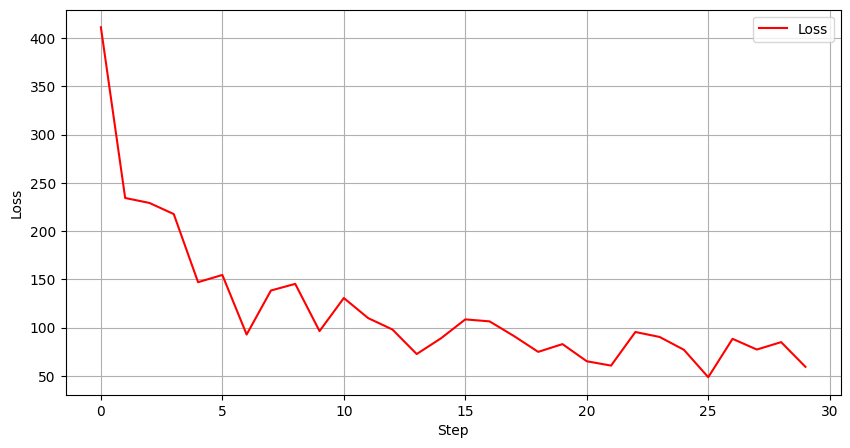

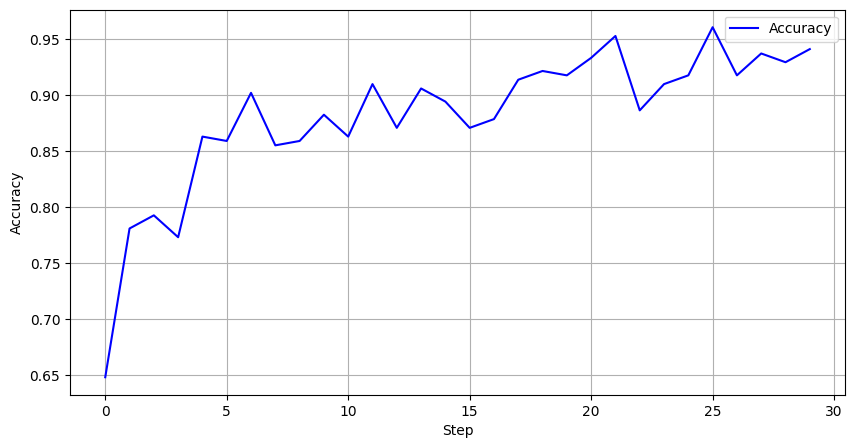

In [77]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

# Виведіть графік функції втрат
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Виведіть графік точності
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, label='Accuracy', color='blue')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [78]:
# Обчисліть точність навченої нейромережі
train_predictions = neural_net(x_train)
train_acc = accuracy(train_predictions, y_train)
print(f"Точність на тренувальних даних: {train_acc:.4f}")
# Тестування моделі на тестових даних
test_predictions = neural_net(x_test)
test_acc = accuracy(test_predictions, y_test)
print(f"Точність на тестових даних: {test_acc:.4f}")

Точність на тренувальних даних: 0.9204
Точність на тестових даних: 0.8976


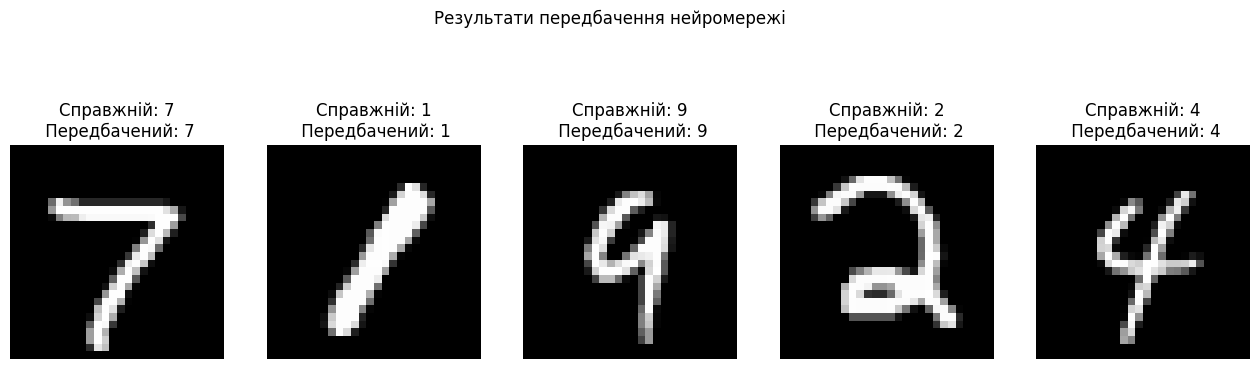

Точність на 10-ти тестових зображеннях: 0.9000
Точність на вибраних зображеннях: 100.00% (5/5)


In [81]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

test_predictions = neural_net(x_test)
test_acc = accuracy(test_predictions[:10], y_test[:10])

num_samples = 5
random_five_indices = random.sample(range(x_test.shape[0]), num_samples)

fig, axes = plt.subplots(1, 5, figsize=(16, 5))
fig.suptitle("Результати передбачення нейромережі")

correct_predictions = 0

for i, idx in enumerate(random_five_indices):
    
    img = x_test[idx]
    true_label = y_test[idx]
    
    pred = neural_net(img[None, ...]) 
    predicted_label = tf.argmax(pred, axis=1).numpy()[0]
    
    if predicted_label == true_label:
        correct_predictions += 1
    
    ax = axes[i]
    ax.imshow(img.reshape(28, 28), cmap="gray")  
    ax.set_title(f"Справжній: {true_label}\n Передбачений: {predicted_label}")
    ax.axis("off")

plt.show()

accuracy_on_sample = correct_predictions / 5 * 100

print(f"Точність на 10-ти тестових зображеннях: {test_acc:.4f}")
print(f"Точність на вибраних зображеннях: {accuracy_on_sample:.2f}% ({correct_predictions}/{num_samples})")

